In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_008910.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08097.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_010290.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08093_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f05040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00660_P.png')]

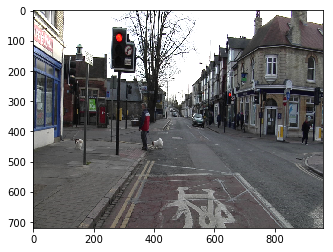

In [8]:
img = Image.open(fnames[3]).convert('RGB')
plt.imshow(img);

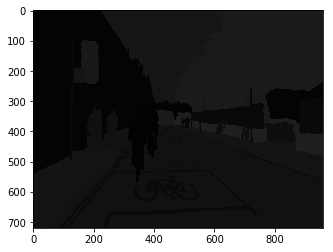

In [9]:
img = Image.open(lbl_names[7]).convert('RGB')
plt.imshow(img);

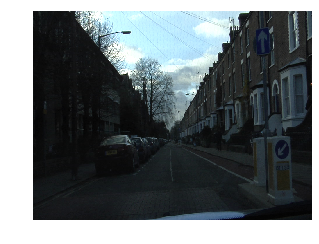

In [12]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

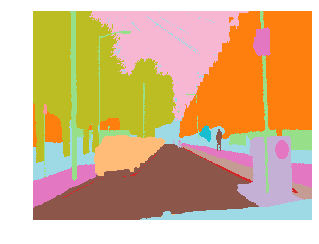

In [14]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [25]:
src_size = np.array(mask.shape[1:])
src_size, mask.shape, mask.data

(array([720, 960]),
 torch.Size([1, 720, 960]),
 tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [16]:
img.shape, img.data

(torch.Size([3, 720, 960]),
 tensor([[[0.0706, 0.0706, 0.0706,  ..., 0.1176, 0.1255, 0.1490],
          [0.0863, 0.0824, 0.0667,  ..., 0.1294, 0.1373, 0.1490],
          [0.0863, 0.0824, 0.0706,  ..., 0.1373, 0.1451, 0.1529],
          ...,
          [0.0706, 0.0745, 0.0824,  ..., 0.0471, 0.0471, 0.0471],
          [0.0706, 0.0745, 0.0824,  ..., 0.0392, 0.0392, 0.0353],
          [0.0706, 0.0745, 0.0824,  ..., 0.0392, 0.0392, 0.0353]],
 
         [[0.0745, 0.0745, 0.0745,  ..., 0.1882, 0.1686, 0.1922],
          [0.0902, 0.0863, 0.0706,  ..., 0.1882, 0.1804, 0.1922],
          [0.0902, 0.0863, 0.0745,  ..., 0.1961, 0.1882, 0.1961],
          ...,
          [0.0745, 0.0784, 0.0863,  ..., 0.0510, 0.0510, 0.0510],
          [0.0745, 0.0784, 0.0863,  ..., 0.0549, 0.0549, 0.0510],
          [0.0745, 0.0784, 0.0863,  ..., 0.0549, 0.0549, 0.0510]],
 
         [[0.0824, 0.0824, 0.0824,  ..., 0.2353, 0.2157, 0.2392],
          [0.0980, 0.0941, 0.0784,  ..., 0.2392, 0.2275, 0.2392],
          [0

In [17]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size = src_size // 2
bs = 4

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
 data = (src.transform(get_transforms(), size=size, tfm_y=True)
         .databunch(bs=bs)
         .normalize(imagenet_stats))

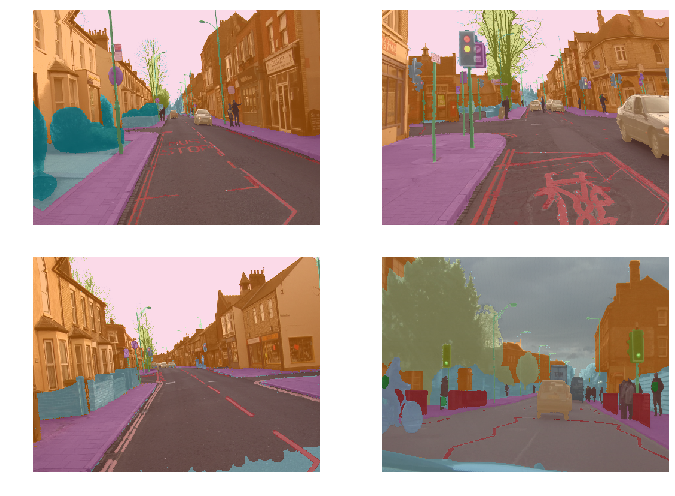

In [21]:
data.show_batch(2, figsize=(10, 7))

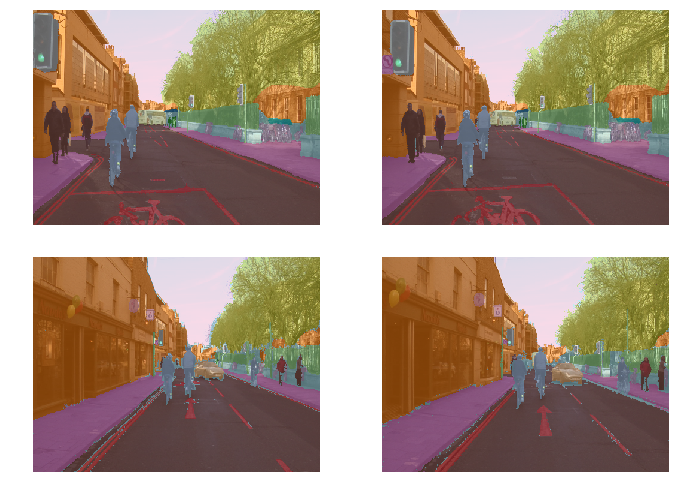

In [24]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [32]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [31]:
np.unique(mask.data)

array([ 4,  5,  8,  9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 26, 29, 30, 31])

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 115249352.03it/s]


In [36]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


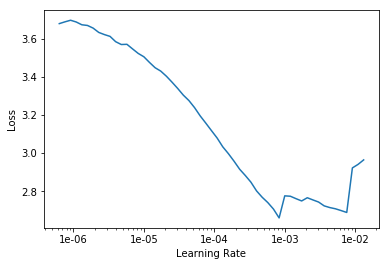

In [42]:
learn.recorder.plot()

In [0]:
lr=3e-4

In [38]:

learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.303789,0.921272,0.786684,01:45
1,0.900348,0.750853,0.825102,01:42
2,0.743766,0.640283,0.831723,01:42
3,0.667045,0.504472,0.859940,01:41
4,0.579300,0.528363,0.855748,01:41
5,0.550759,0.440066,0.880127,01:41
6,0.520054,0.391950,0.889721,01:41
7,0.487204,0.373615,0.899569,01:40
8,0.433951,0.370217,0.894489,01:40
9,0.393194,0.309239,0.908922,01:40


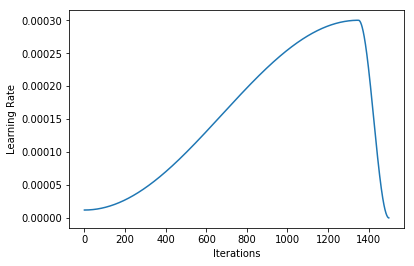

In [39]:
learn.recorder.plot_lr()

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

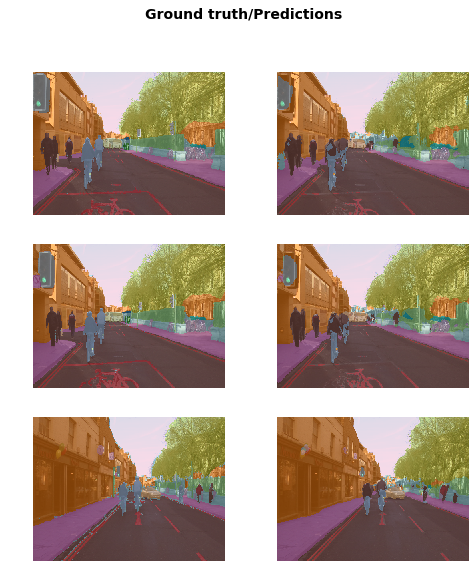

In [42]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [45]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.333033,0.303207,0.909861,01:45
1,0.334153,0.301084,0.910299,01:45
2,0.336837,0.300496,0.911174,01:45
3,0.327389,0.291923,0.914060,01:45
4,0.328468,0.283690,0.919017,01:45
5,0.309069,0.279919,0.918200,01:45
6,0.303468,0.299501,0.913713,01:45
7,0.300043,0.314687,0.904703,01:45
8,0.286525,0.285852,0.918497,01:45
9,0.277782,0.296525,0.913215,01:45


In [0]:
learn.save('stage-2');

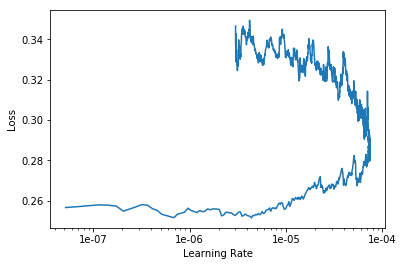

In [47]:
learn.recorder.plot()

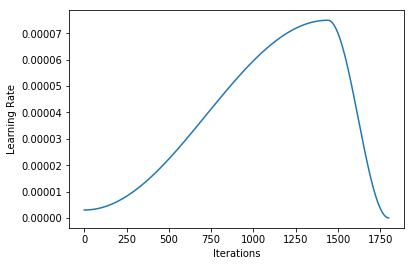

In [48]:
learn.recorder.plot_lr()

In [0]:
size = src_size
bs=2

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


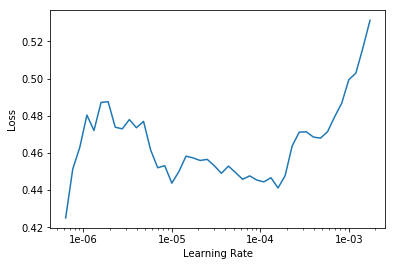

In [62]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-4

In [64]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.377510,0.317441,0.910146,06:34
1,0.341034,0.325464,0.906037,06:30
2,0.345128,0.306653,0.911213,06:30
3,0.339876,0.304888,0.912631,06:31
4,0.326683,0.314924,0.912216,06:30
5,0.318709,0.301082,0.910748,06:29
6,0.317096,0.301518,0.912840,06:29
7,0.311788,0.311522,0.912615,06:28
8,0.284224,0.284029,0.917674,06:28
9,0.235899,0.264909,0.923446,06:28


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

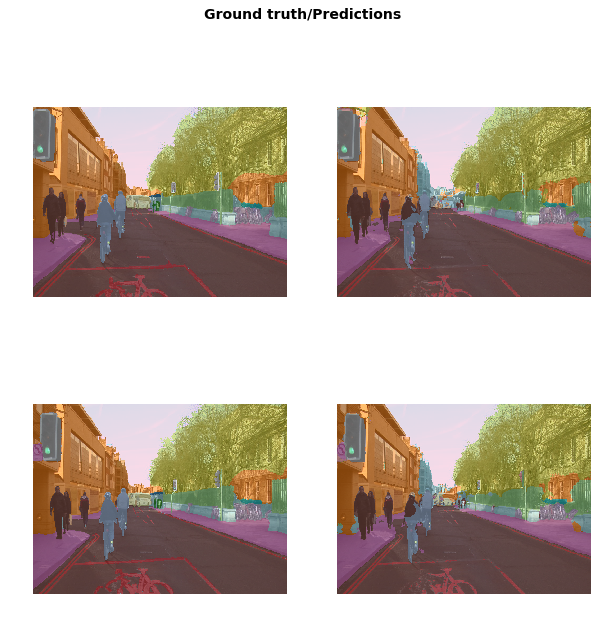

In [68]:
learn.show_results(rows=3, figsize=(10,10))